This notebook uses auto-regression techniques to study the behavior in the calibration value.

In [1]:
#import the stuff
import pandas as pd #dataframes etc
import matplotlib.pyplot as plt #plotting
import numpy as np
from sklearn import preprocessing
from common.utils import TimeSeriesTensor, create_evaluation_df, mape, scale_shrinker

In [3]:
#load the data
xtal = 54004
test = pd.read_csv('../data/test_diff_{}.csv'.format(xtal), index_col=0)
valid = pd.read_csv('../data/valid_diff_{}.csv'.format(xtal), index_col=0)
train = pd.read_csv('../data/train_diff_{}.csv'.format(xtal), index_col=0)
#set index to datetime periods
#test.index = pd.to_datetime(test.index).to_period('H')
#valid.index = pd.to_datetime(valid.index).to_period('H')
#train.index = pd.to_datetime(train.index).to_period('H')
#set index to datetime
test.index = pd.to_datetime(test.index)
valid.index = pd.to_datetime(valid.index)
train.index = pd.to_datetime(train.index)

full = train.append([valid,test])

#df.index = pd.DatetimeIndex(df.index).to_period('M')
#only take calibration values
test = test[['p2']]
valid = valid[['p2']]
train = train[['p2']]



In [21]:
#scale full
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = StandardScaler()
full[['p2', 'int_deliv_inv_ub']] = scaler.fit_transform(full)

full.head()

,p2,int_deliv_inv_ub
2018-05-12 09:01:31,0.497511,0.427552
2018-05-12 10:01:31,0.388708,0.349726
2018-05-12 11:01:31,0.597464,0.274367
2018-05-12 12:01:31,0.953665,1.337635
2018-05-12 13:01:31,1.082681,1.222461


In [22]:
test.head()

,p2
2018-10-15 01:36:23,0.000004
2018-10-15 02:36:23,0.000024
2018-10-15 03:36:23,0.000057
2018-10-15 04:36:23,0.000041
2018-10-15 05:36:23,0.000108


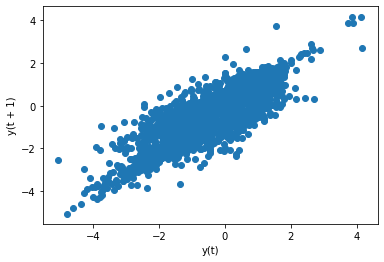

In [23]:
pd.plotting.lag_plot(full.p2, lag=1)

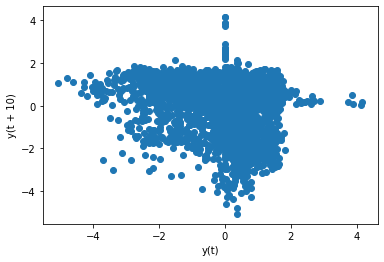

In [24]:
pd.plotting.lag_plot(full.p2, lag=10)

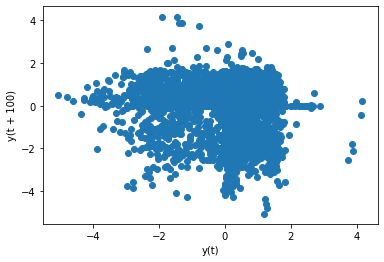

In [25]:
pd.plotting.lag_plot(full.p2, lag=100)

In [26]:
#pd.plotting.lag_plot(test.int_deliv_inv_ub, lag=1)

In [27]:
#pd.plotting.lag_plot(test.int_deliv_inv_ub, lag=10)

In [28]:
#pd.plotting.lag_plot(test.int_deliv_inv_ub, lag=100)

(-0.5, 1)

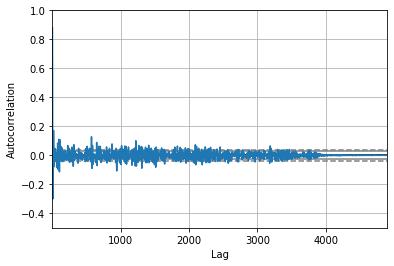

In [29]:
pd.plotting.autocorrelation_plot(full.p2)
plt.ylim([-0.5, 1])

In [30]:
#pd.plotting.autocorrelation_plot(test.int_deliv_inv_ub)
#plt.ylim([-.2,1])

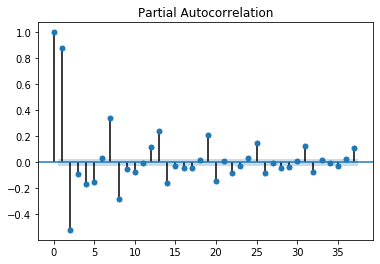

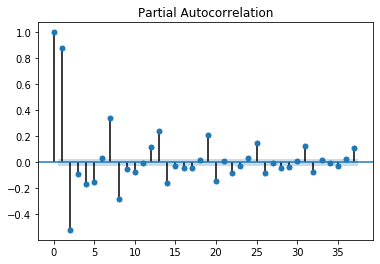

In [31]:
#partial auto-correlation
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(full.p2)

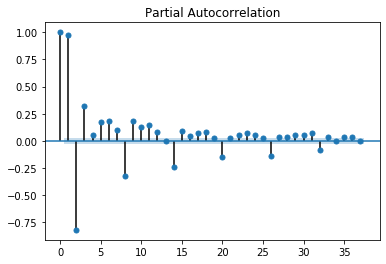

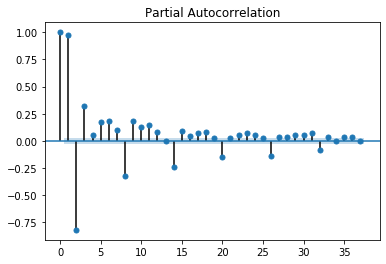

In [32]:
plot_pacf(full.int_deliv_inv_ub)

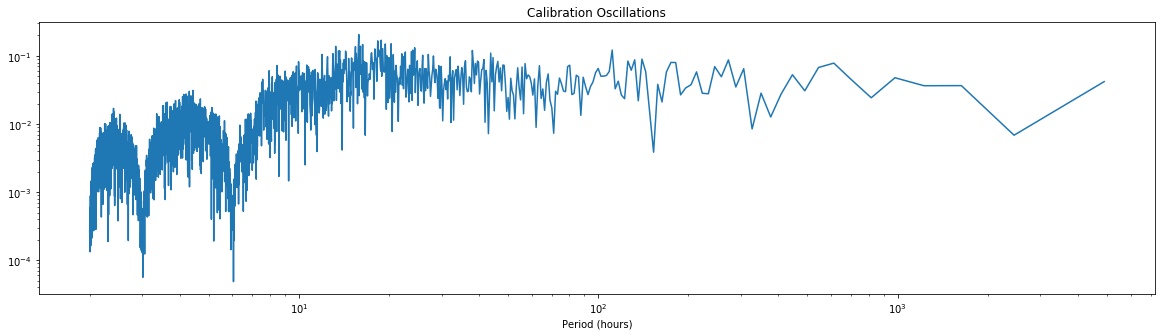

In [35]:
from scipy.fftpack import fft, fftfreq
#scipy.fft(full.p2)
yf = fft(full.p2)
N = full.p2.size
T = 1
#xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
xf = fftfreq(N, T)[1:N//2]
fig, ax = plt.subplots(figsize=(20,5))

ax.plot(1.0/xf, 2.0/N * np.abs(yf[1:N//2]))
#plt.plot(xf)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Period (hours)')
ax.set_title('Calibration Oscillations')
fig.show()

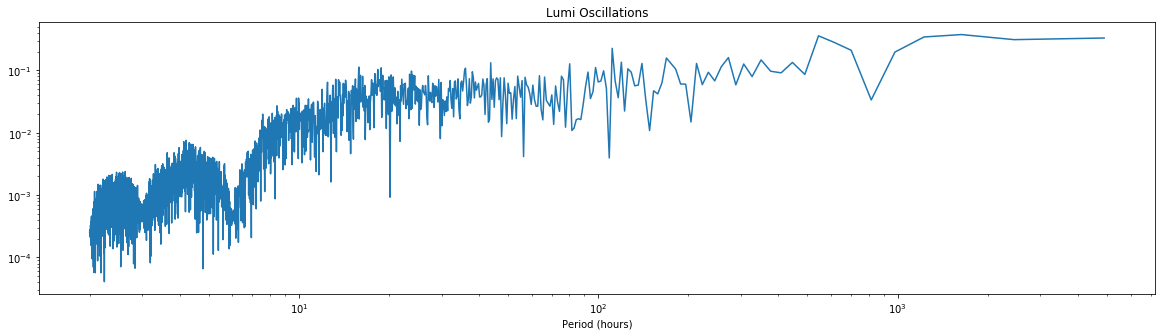

In [36]:
#scipy.fft(full.p2)
yf = fft(full.int_deliv_inv_ub)
N = full.int_deliv_inv_ub.size
T = 1
#xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
xf = fftfreq(N, T)[1:N//2]
fig, ax = plt.subplots(figsize=(20,5))

ax.plot(1.0/xf, 2.0/N * np.abs(yf[1:N//2]))
#plt.plot(xf)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Period (hours)')
ax.set_title('Lumi Oscillations')
fig.show()

In [37]:
full.corr()

,p2,int_deliv_inv_ub
p2,1.000000,-0.390712
int_deliv_inv_ub,-0.390712,1.000000


In [42]:
#now lets try some autoregression
import seaborn as sns
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.api import acf, pacf, graphics

In [43]:
model = AutoReg(full.p2, 10, old_names=True)
results = model.fit()
results.summary()

/home/rusack/evans908/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                     p2   No. Observations:                 4900
Model:                    AutoReg(10)   Log Likelihood               34567.746
Method:               Conditional MLE   S.D. of innovations              0.000
Date:                Wed, 24 Mar 2021   AIC                            -16.971
Time:                        15:31:29   BIC                            -16.955
Sample:                            10   HQIC                           -16.966
                                 4900                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   7.165e-07   2.94e-06      0.243      0.808   -5.06e-06    6.49e-06
p2.L1          1.3539      0.014     94.917      0.000       1.326       1.382
p2.L2         -0.4924      0.024    -20.484      0.000      -0.539      -0.445
p2.L3          0.0499      0.025      2.014      0.044       0.001       0.098
p2.L4         -0.0197      0.023     -0.865      0.387      -0.064       0.025
p2.L5         -0.0190      0.022     -0.876      0.381      -0.062       0.024
p2.L6         -0.4893      0.022    -22.508      0.000      -0.532      -0.447
p2.L7          0.6745      0.023     29.542      0.000       0.630       0.719
p2.L8         -0.2538      0.025    -10.244      0.000      -0.302      -0.205
p2.L9          0.0334      0.024      1.389      0.165      -0.014       0.080
p2.L10        -0.0556      0.014     -3.898      0.000      -0.084      -0.028
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1            -0.9791           -0.5497j            1.1229           -0.4186
AR.2            -0.9791           +0.5497j            1.1229            0.4186
AR.3             0.0117           -1.1173j            1.1173           -0.2483
AR.4             0.0117           +1.1173j            1.1173            0.2483
AR.5             0.9582           -0.6446j            1.1548           -0.0943
AR.6             0.9582           +0.6446j            1.1548            0.0943
AR.7             1.0929           -0.3169j            1.1379           -0.0449
AR.8             1.0929           +0.3169j            1.1379            0.0449
AR.9            -0.7835           -2.4506j            2.5728           -0.2992
AR.10           -0.7835           +2.4506j            2.5728            0.2992
------------------------------------------------------------------------------
"""

No handles with labels found to put in legend.


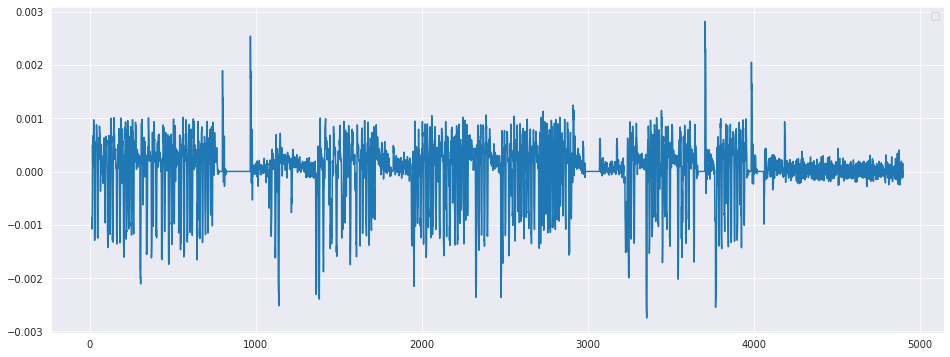

In [44]:
sns.set_style('darkgrid')
pd.plotting.register_matplotlib_converters()
sns.mpl.rc('figure', figsize=(16,6))

figure = results.plot_predict()

/home/rusack/evans908/.local/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/rusack/evans908/.local/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


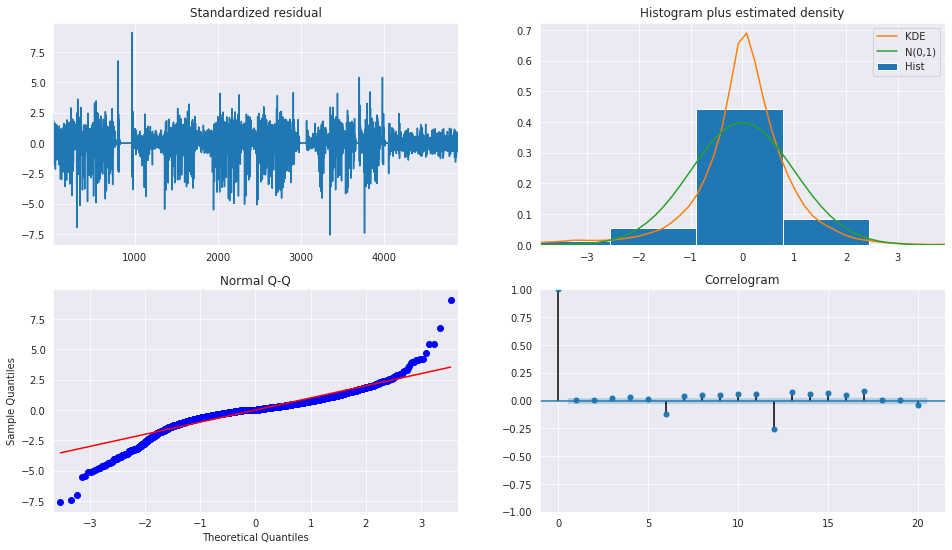

In [45]:
fig = plt.figure(figsize=(16,9))
fig = results.plot_diagnostics(fig=fig, lags=20)

In [46]:
#lets pool the valid and train data together
train = train.append(valid)
train.idxmax()
train.loc['2018-10-13 22:15:27']

p2    0.002569
Name: 2018-10-13 22:15:27, dtype: float64

In [47]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train['p2'] = scaler.fit_transform(train)[:,0]
train.head()

,p2
2018-05-12 09:01:31,0.606049
2018-05-12 10:01:31,0.599961
2018-05-12 11:01:31,0.611185
2018-05-12 12:01:31,0.652975
2018-05-12 13:01:31,0.672792


In [48]:
print(scaler.n_samples_seen_,scaler.data_max_,scaler.data_min_)


3734 [0.00259204] [-0.00319234]


In [49]:
test['p2'] = scaler.transform(test)

#Number of steps to forecast ahead
test_shifted = test.copy()
HORIZON = 3
#create test data points for each horizon
for t in range(1, HORIZON):
    test_shifted['p2+'+str(t)] = test_shifted['p2'].shift(-t, freq='H')
                 
test_shifted = test_shifted.dropna(how='any')
test_shifted.head(5)

,p2,p2+1,p2+2
2018-10-15 01:36:23,0.567938,0.561589,0.571146
2018-10-15 02:36:23,0.561589,0.571146,0.575498
2018-10-15 03:36:23,0.571146,0.575498,0.579173
2018-10-15 04:36:23,0.575498,0.579173,0.594053
2018-10-15 05:36:23,0.579173,0.594053,0.579938


In [50]:
#make predictions on the test data
training_window = 500
train_series = train['p2']
test_series = test_shifted




for lag in range(10,11):
    history = [x for x in train_series]
    history = history[(-training_window):]
    predictions = list()
    for t in range(test_series.shape[0]):
        model = AutoReg(history, lag, old_names=False)
        model_fit = model.fit()
        yhat = model_fit.forecast(steps=HORIZON)
        predictions.append(yhat)
        obs = list(test_series.iloc[t])
     
        # move the training window
        history.append(obs[0])
        history.pop(0)
        #print(test_series.index[t])
        #print(t+1, ': predicted =', yhat, 'expected =', obs)
    pred_np = np.array(predictions)
    #calculate MAPE
    mape1 = mape(pred_np[:,0], test_series['p2'])
    mape2 = mape(pred_np[:,1], test_series['p2+1'])
    mape3 = mape(pred_np[:,2], test_series['p2+2'])
    print('Evaluating AR({}):'.format(lag))
    print("MAPE prediction 1 hour  ahead: {:.1%}".format(mape1),
              "\nMAPE prediction 2 hours ahead: {:.1%}".format(mape2),
              "\nMAPE prediction 3 hours ahead: {:.1%}".format(mape3))

Evaluating AR(10):
MAPE prediction 1 hour  ahead: 3.2% 
MAPE prediction 2 hours ahead: 4.8% 
MAPE prediction 3 hours ahead: 6.1%


In [51]:
#not much change, but AR(10) does marginally better than the rest

/home/rusack/evans908/.local/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/rusack/evans908/.local/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/rusack/evans908/.local/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


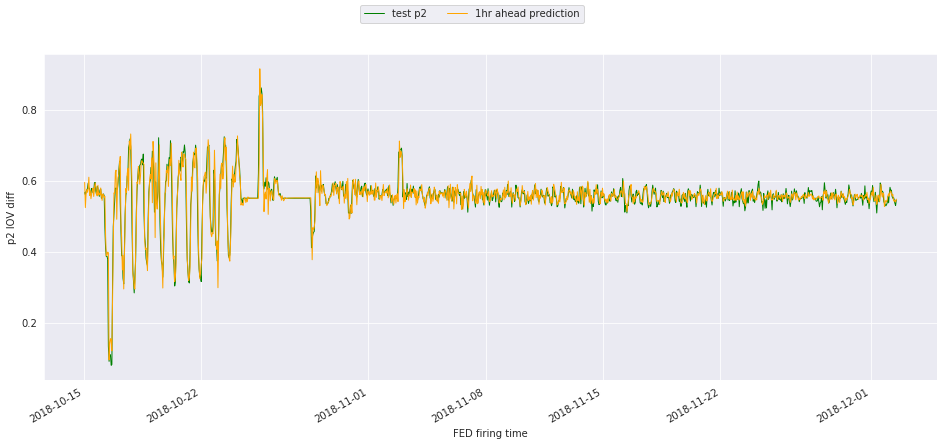

In [52]:
#lets make some plots
fig, ax = plt.subplots()

ax.set_ylabel('p2 IOV diff')
ax.set_xlabel('FED firing time')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')

#actual data
ax.plot(test_series.index, test_series.p2, 
         label='test p2', color='green', linewidth=1, linestyle='solid')
ax.plot(test_series.index, pred_np[:,0], 
         label='1hr ahead prediction', color='orange', linewidth=1, linestyle='solid')
#legend
fig.legend(ncol=3, loc = 'upper center')
fig.show()

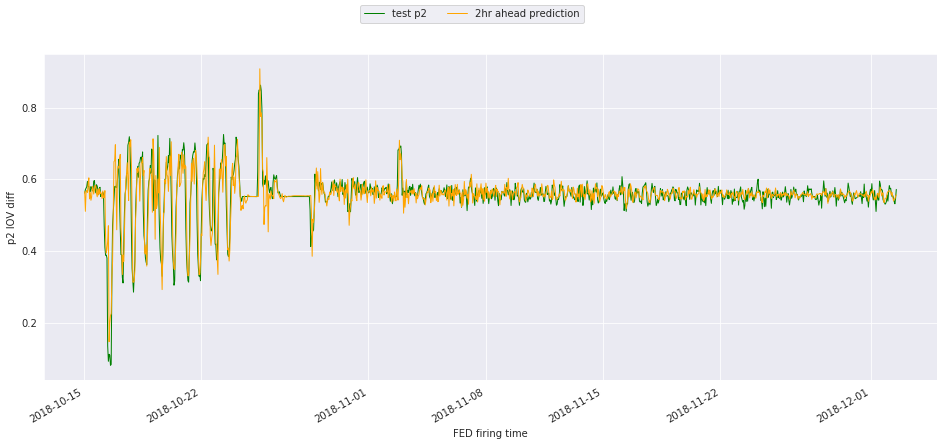

In [53]:
#lets make some plots
fig, ax = plt.subplots()

ax.set_ylabel('p2 IOV diff')
ax.set_xlabel('FED firing time')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')

#actual data
ax.plot(test_series.index, test_series['p2+1'], 
         label='test p2', color='green', linewidth=1, linestyle='solid')
ax.plot(test_series.index, pred_np[:,1], 
         label='2hr ahead prediction', color='orange', linewidth=1, linestyle='solid')
#legend
fig.legend(ncol=3, loc = 'upper center')
fig.show()


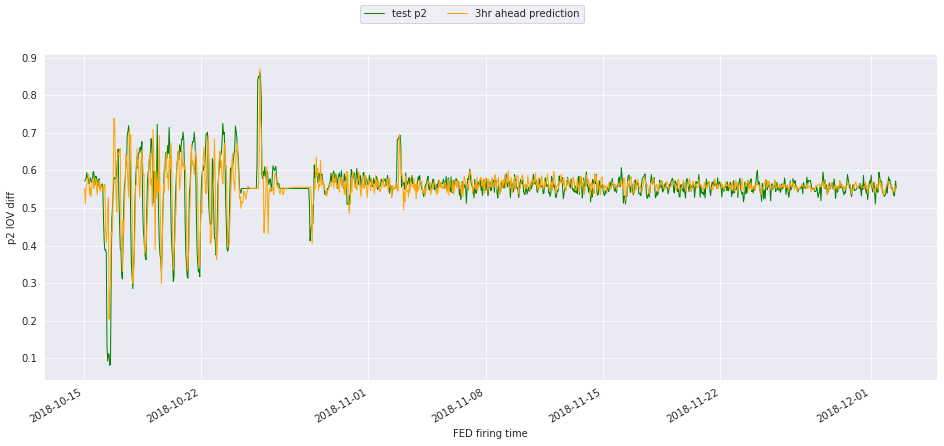

In [54]:
#lets make some plots
fig, ax = plt.subplots()

ax.set_ylabel('p2 IOV diff')
ax.set_xlabel('FED firing time')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')

#actual data
ax.plot(test_series.index, test_series['p2+2'], 
         label='test p2', color='green', linewidth=1, linestyle='solid')
ax.plot(test_series.index, pred_np[:,2], 
         label='3hr ahead prediction', color='orange', linewidth=1, linestyle='solid')
#legend
fig.legend(ncol=3, loc = 'upper center')
fig.show()

In [55]:
test_inv = test.iloc[:-2,:].copy()
test_inv

,p2
2018-10-15 01:36:23,0.567938
2018-10-15 02:36:23,0.561589
2018-10-15 03:36:23,0.571146
2018-10-15 04:36:23,0.575498
2018-10-15 05:36:23,0.579173
...,...
2018-12-02 08:36:23,0.554323
2018-12-02 09:36:23,0.547731
2018-12-02 10:36:23,0.537560
2018-12-02 11:36:23,0.531666


In [56]:
test_inv['p2'] = scaler.inverse_transform(test_inv)
test_inv = test_inv.cumsum()
pred_df = pd.DataFrame(pred_np, columns=['p2','p2+1','p2+2'])[['p2']]
pred_df['p2'] = scaler.inverse_transform(pred_df)
pred_df = pred_df.cumsum()
pred_df

,p2
0,0.000258
1,0.000105
2,0.000162
3,0.000303
4,0.000399
...,...
1159,0.030905
1160,0.030853
1161,0.030822
1162,0.030762


/home/rusack/evans908/.local/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/rusack/evans908/.local/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/rusack/evans908/.local/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


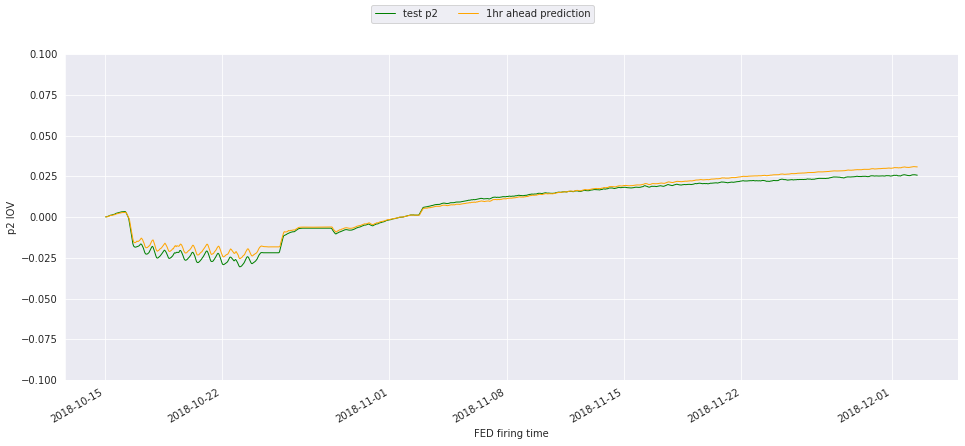

In [57]:
#lets make some plots
fig, ax = plt.subplots()

ax.set_ylabel('p2 IOV')
ax.set_xlabel('FED firing time')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')

#actual data
ax.plot(test_inv.index, test_inv['p2'], 
         label='test p2', color='green', linewidth=1, linestyle='solid')
ax.plot(test_inv.index, pred_df['p2'], 
         label='1hr ahead prediction', color='orange', linewidth=1, linestyle='solid')
#legend
plt.ylim(-0.1,0.1)
fig.legend(ncol=3, loc = 'upper center')
fig.show()